In [3]:
from itertools import count
import os
import gc
import time
import pandas as pd
import numpy as np
import zmq
import DRL_pb2

from agent.main import Agent
from agent.actorcritic import OUNoise
from emulator.main import Account

from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set_style('whitegrid')
%matplotlib inline

from params import *

#mail
import smtplib
from email.mime.text import MIMEText
from email.header import Header
from smtplib import SMTP_SSL

from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

import visdom

mail_content = ""
mail_title = 'Backtest Result'

msg = MIMEMultipart('related')
msg["Subject"] = Header(mail_title, 'utf-8')
msg["From"] = sender_qq_mail
msg["To"] = Header("Backtest Result", 'utf-8') ## 接收者的别名

msgAlternative = MIMEMultipart('alternative')
msg.attach(msgAlternative)

mail_body = """
 <p>Result：</p>
"""

msgText = (MIMEText(mail_body, 'html', 'utf-8'))
msgAlternative.attach(msgText)


#zmq
context = zmq.Context()
socket = context.socket(zmq.PUB)
socket.bind('ipc:///tmp/DRL')
DRL = DRL_pb2.Agent_Info()

Instrument_ID='HS300'

In [4]:
env = Account(tSD, tED, Instrument_ID ,True)
state = env.reset()
ou_noise = OUNoise(ACTION_SIZE)

image_shape = state.shape
agent = Agent(image_shape, ACTION_SIZE)

print(env.data_observation.shape)
print(image_shape)

#viz_loss = visdom.Visdom(env = Instrument_ID + '_Cycle_Trainning_Loss')
#viz_reward = visdom.Visdom(env = Instrument_ID + '_Cycle_Trainning_Reward')

time to oSD days
546
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
(628, 50, 23, 2)
(2, 50, 23)


In [3]:
#def viz_loss_plot(viz_step, c_loss, a_loss):
#    viz_loss.line(Y = np.array([c_loss]), X = np.array([viz_step]), update = 'append', win = C_loss, \
#                  opts = dict(title = 'Critic Loss'))
#    viz_loss.line(Y = np.array([a_loss]), X = np.array([viz_step]), update = 'append', win = A_loss, \
#                  opts = dict(title = 'Actor Loss'))
#    
#def viz_reward_plot(cycle, frame_idx, rewards):
#    title_name = 'Cycle ' + str(cycle) + '   Frame ' + str(frame_idx) + ' Reward  ' + str(rewards)
#    viz_reward.line(Y = np.array([rewards]),   X = np.array([frame_idx]), update = 'append',win = Reward, \
#                   opts = dict(title = title_name))

(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2


FileNotFoundError: [Errno 2] No such file or directory: './figure/样本外/HS300/0.png'

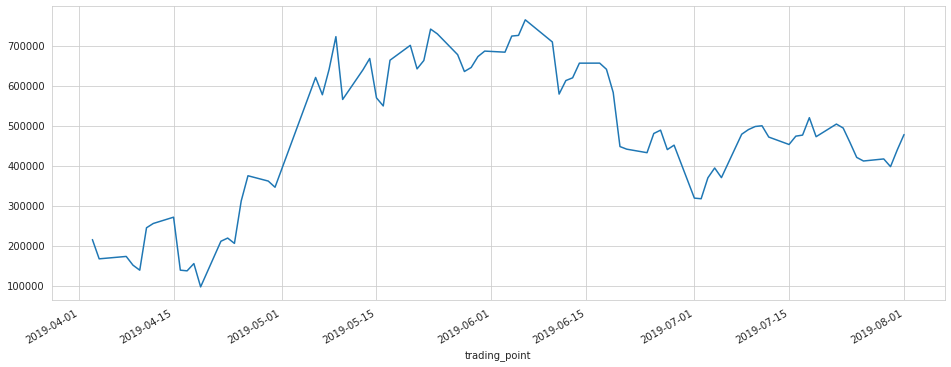

In [4]:
for cycle_times in range(150):
    
    max_episodes = 2
    global_step = 0

    episode_reward = 0

    all_rewards = []
    a_losses = []
    c_losses = []
    c_loss = 0
    a_loss = 0
    
    ou_noise = OUNoise(ACTION_SIZE)
    agent = Agent(image_shape, ACTION_SIZE)
    
    time.sleep(4)
    
    '''viz_loss.close()
    viz_reward.close()
    C_loss = viz_loss.line(np.arange(20))
    A_loss = viz_loss.line(np.arange(20))
    Reward = viz_reward.line(np.arange(20))'''
    viz_loss_step = 0
    viz_reward_step = 0

    for episode in range(max_episodes):
        state = env.reset()
        ou_noise.reset()
        
        episode_step = 0
        
        cache_reward = []
        cache_value = []
        while True:
            global_step += 1
            episode_step += 1
        
            #print(episode)
            action = agent.get_exploration_policy(np.expand_dims(state, 0))
            action = ou_noise.get_action(action, episode_step)
            next_state, reward, done = env.step(action, Instrument_ID)
            
            agent.append(state, action, reward, done, next_state)
            state = next_state

            cache_reward.append(reward)
            cache_value.append(env.total_value)
            episode_reward += reward
        
            if agent.get_cache_len() > 600:
                beta = beta_by_frame(episode_step)
                c_loss, a_loss = agent.optimize(beta)
        
            if episode_step % 100 == 0 and agent.get_cache_len() > 600:
                a_losses.append(a_loss)
                c_losses.append(c_loss)
                #viz_loss_step += 100
                #viz_loss_plot(viz_loss_step, c_loss.item(), a_loss.item())
                #plot_loss(cycle_times, episode, all_rewards, c_losses, a_losses)
        
            if done:
                all_rewards.append(env.total_value)
                #viz_reward_plot(cycle_times, episode, np.mean(all_rewards[-10:]))
                gc.collect()
                mod_no = 9999 + math.sin(math.pi/2 * (episode % 2))
                agent.save_model(Instrument_ID, mod_no)
                
                DRL.train_done = True
                DRL.episode = episode
                s_msg = DRL.SerializeToString()
                socket.send(s_msg)
                
                time.sleep(10)
                break
                
    agent.save_model(Instrument_ID, cycle_times)
    state = env.reset()
    agent_t = Agent(image_shape, ACTION_SIZE)
    agent_t.load_model(Instrument_ID, cycle_times)
    for i in range(Full_Size - 1):
        action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
        next_state, reward, done = env.step(action, Instrument_ID)
        state = next_state
        
    tmp = env.plot_data()
    tmp.iloc[Smp_Size:, 0].plot(figsize=(16, 6))
    pic_name ='./figure/'+ Instrument_ID + '/' + str(cycle_times) + '.png'
    if os.path.isfile(pic_name):
        os.remove(pic_name)
    plt.savefig(pic_name)
    

all_ed = time.clock()
print('Total Using Time %s Hours'%((all_ed-all_st)/3600))